In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sb

root = os.path.dirname(os.getcwd())
exa_root = '/home/jorgemarpa/data/'

# Metadata

In [19]:
meta = np.load('%s/imgs/PPD/param_arr_gridandfiller123.npy' % (exa_root))
meta = pd.DataFrame(meta, columns=['m_dust', 'Rc', 'f_exp', 'H0', 
                                   'Rin', 'sd_exp', 'a_max', 'inc'],
                    dtype=np.float32)
meta.head()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
0,1.000000e-07,100.0,1.15,5.0,0.1,0.0,10.0,90.0
1,1.000000e-07,100.0,1.15,5.0,0.1,-0.5,10.0,90.0
2,1.000000e-07,100.0,1.15,5.0,0.1,-1.0,10.0,90.0
3,1.000000e-07,100.0,1.15,5.0,1.0,-0.5,10.0,90.0
4,1.000000e-07,100.0,1.15,5.0,1.0,-1.0,10.0,90.0


In [20]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99825 entries, 0 to 99824
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   m_dust  99825 non-null  float32
 1   Rc      99825 non-null  float32
 2   f_exp   99825 non-null  float32
 3   H0      99825 non-null  float32
 4   Rin     99825 non-null  float32
 5   sd_exp  99825 non-null  float32
 6   a_max   99825 non-null  float32
 7   inc     99825 non-null  float32
dtypes: float32(8)
memory usage: 3.0 MB


In [21]:
meta.describe()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
count,9.982500e+04,99825.000000,99825.000000,99825.000000,99825.000000,99825.000000,99825.000000,99825.000000
mean,3.334325e-04,152.462112,1.076220,13.996884,2.691983,-0.745420,1384.944336,82.271339
std,3.702816e-04,93.009193,0.142533,4.562022,3.427400,0.477791,2716.636963,6.719990
min,1.000000e-07,10.000000,0.850000,5.000000,0.100000,-1.500000,10.000000,52.692574
25%,3.490000e-05,83.000000,0.972000,10.000000,0.300000,-1.101553,28.834574,78.344276
50%,1.150000e-04,128.800003,1.076000,15.000000,1.000000,-0.747504,114.347610,84.202362
75%,6.070000e-04,237.399994,1.183000,18.000000,3.900000,-0.382522,1000.000000,87.104897
max,1.000000e-03,300.000000,1.300000,20.000000,10.000000,0.000000,10000.000000,90.000000


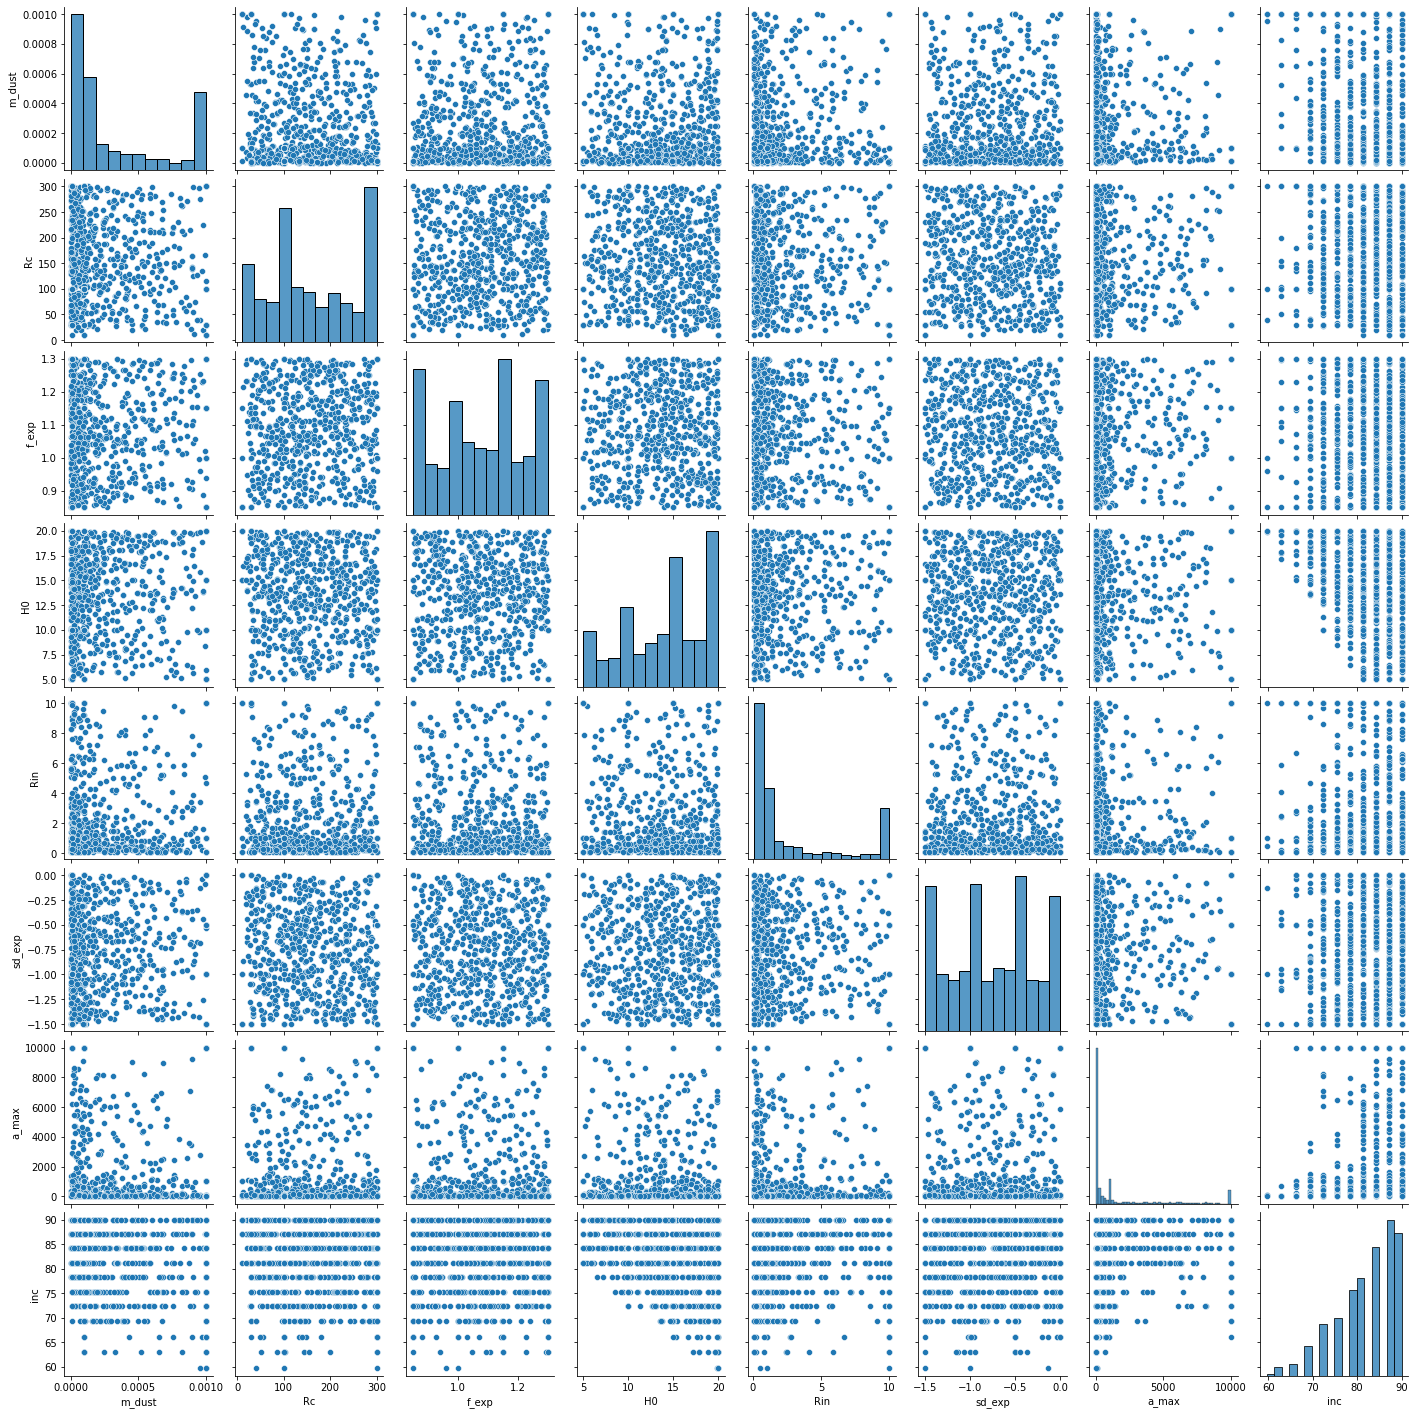

In [23]:
sb.pairplot(meta.sample(1000))
plt.show()

# Synthetic Images

In [5]:
imgs = np.load('%s/imgs/PPD/img_array_gridandfiller123_norm.npy' % (exa_root))
#imgs = np.expand_dims(imgs, axis=1)
imgs.shape

(99825, 1, 187, 187)

In [6]:
print('Min ', imgs.min(), 'Max ', imgs.max())
print('Mean ', imgs.mean(), 'Std ', imgs.std())

Min  0.0 Max  1.0
Mean  1.2840572e-05 Std  0.00042697394


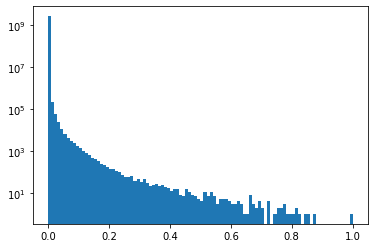

In [104]:
plt.hist(imgs.flatten(), bins=100, log=True)
plt.show()

In [7]:
def plot_wall(x):
    """Light-curves wall plot, function used during VAE training phase.
    Figure designed and ready to be appended to W&B logger.

    Parameters
    ----------
    xhat : numpy array
        Array of generated light curves
    x    : numpy array
        List of real light curves.
    epoch: int, optional
        Epoch number

    Returns
    -------
    fig
        a matplotlib figure
    image
        an image version of the figure
    """

    plt.close('all')
    ncols = 10
    v_min = np.min(x)
    v_max = np.max(x)
    norm = colors.SymLogNorm(linthresh=.0005, linscale=100,
                             vmin=v_min, vmax=v_max)
    print(v_min, v_max)
    fig, axis = plt.subplots(nrows=ncols, ncols=ncols, figsize=(ncols, ncols))
    for i, ax in enumerate(axis.ravel()):
        ax.imshow(x[i, 0, :, :], interpolation='bilinear',
                  cmap=cm.viridis, origin='upper', aspect='equal',
                  norm=norm)

    for ax in axis.ravel():
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)#, left=0, right=1)
    #plt.tight_layout()
    #fig.suptitle('Synthetic Images', fontsize=20, y=.95)
    plt.show()
    return

0.0 0.1552998


<ipython-input-7-9f862259f7c1>:26: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=.0005, linscale=100,


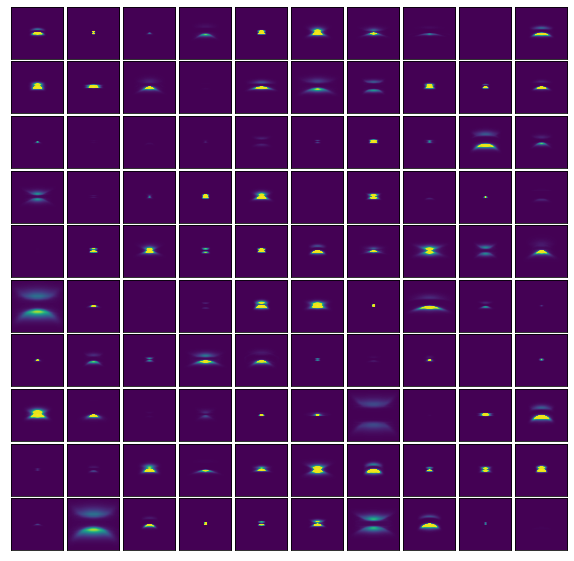

In [8]:
idx = np.random.randint(0, imgs.shape[0], size=100)
plot_wall(imgs[idx])

In [12]:
meta.iloc[idx].describe()

,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
count,100,100,100,100,100,100,100,100
unique,71,71,67,53,39,72,72,9
top,0.001,300.0,0.85,20.0,10.0,-1.0,1000.0,90.0
freq,14,13,12,13,15,10,10,24


In [24]:
big = meta.query('m_dust == 0.001 and Rc == 300 and f_exp == 1.3 and H0 == 20').index.values
print(meta.iloc[big].shape)
meta.iloc[big].tail()

(452, 8)


,m_dust,Rc,f_exp,H0,Rin,sd_exp,a_max,inc
36513,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,78.344276
36514,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,81.284813
36515,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,84.202362
36516,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,87.104897
36517,0.001,300.0,1.3,20.0,10.0,-1.5,10000.0,90.000000


<ipython-input-7-9f862259f7c1>:26: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = colors.SymLogNorm(linthresh=.0005, linscale=100,


8.4138115e-08 0.28580937


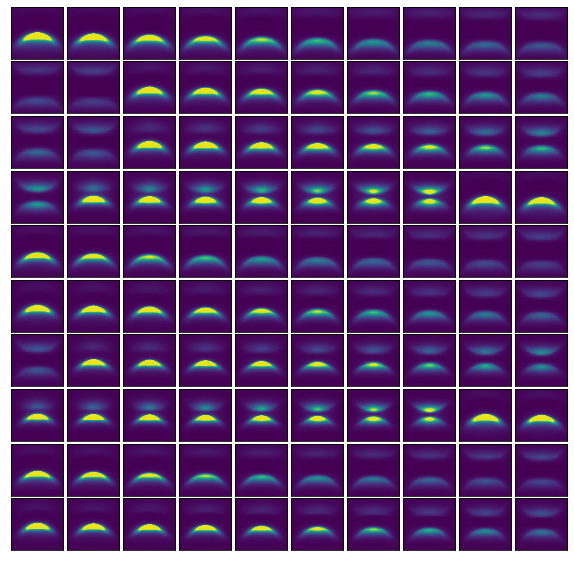

In [25]:
#plot_wall(imgs[np.random.choice(big, size=100, replace=False)])
plot_wall(imgs[big[:100]])

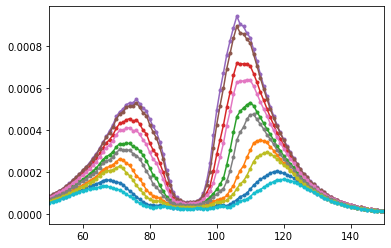

In [35]:
for k in range(50, 150, 10):
    plt.plot(imgs[big[36],0,:,k], '.-')
plt.xlim(50, 150)
plt.show()


# Train / Val / Test splits

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_idx, test_idx = train_test_split(np.arange(imgs.shape[0]), 
                                       test_size=.2, random_state=99)
train_idx.shape, test_idx.shape

((79860,), (19965,))

In [12]:
np.save('%s/imgs/PPD/partitions/param_arr_gridandfiller123_train.npy' % 
        (exa_root), meta.iloc[train_idx].values.astype(np.float32))
np.save('%s/imgs/PPD/partitions/param_arr_gridandfiller123_test.npy' % 
        (exa_root), meta.iloc[test_idx].values.astype(np.float32))

np.save('%s/imgs/PPD/partitions/img_array_gridandfiller123_norm_train.npy' % 
        (exa_root), imgs[train_idx])
np.save('%s/imgs/PPD/partitions/img_array_gridandfiller123_norm_test.npy' % 
        (exa_root), imgs[test_idx])

# Separate images by batches

In [13]:
n_batches = 8
batch_lims = np.linspace(0, train_idx.shape[0], n_batches+1, dtype=int)
print(batch_lims)

[    0  9982 19965 29947 39930 49912 59895 69877 79860]


In [14]:
train_imgs = imgs[train_idx]
train_pars = meta.iloc[train_idx].values.astype(np.float32)

In [15]:
counter = 0
for k in range(n_batches):
    print([batch_lims[k] , batch_lims[k+1]])
    aux_img = train_imgs[batch_lims[k] : batch_lims[k+1]]
    aux_par = train_pars[batch_lims[k] : batch_lims[k+1]]
    print(aux_img.shape, aux_par.shape)
    counter += aux_img.shape[0]
    
    np.save('%s/imgs/PPD/partitions/param_arr_gridandfiller123_train_%i.npy' % 
        (exa_root, k+1), aux_par)
    np.save('%s/imgs/PPD/partitions/img_array_gridandfiller123_norm_train_%i.npy' % 
        (exa_root, k+1), aux_img)
    print('-----------------------')
    
print(counter)

[0, 9982]
(9982, 1, 187, 187) (9982, 8)
-----------------------
[9982, 19965]
(9983, 1, 187, 187) (9983, 8)
-----------------------
[19965, 29947]
(9982, 1, 187, 187) (9982, 8)
-----------------------
[29947, 39930]
(9983, 1, 187, 187) (9983, 8)
-----------------------
[39930, 49912]
(9982, 1, 187, 187) (9982, 8)
-----------------------
[49912, 59895]
(9983, 1, 187, 187) (9983, 8)
-----------------------
[59895, 69877]
(9982, 1, 187, 187) (9982, 8)
-----------------------
[69877, 79860]
(9983, 1, 187, 187) (9983, 8)
-----------------------
79860


In [95]:
train_imgs[42182], train_pars[42182]

(array([[[3.3664294e-14, 3.9188467e-14, 4.5644525e-14, ...,
          4.9280018e-14, 4.2231680e-14, 3.6464497e-14],
         [4.1011570e-14, 4.8524962e-14, 6.0227315e-14, ...,
          7.0670805e-14, 5.3179524e-14, 4.4683824e-14],
         [5.1758670e-14, 6.9626827e-14, 1.0154186e-13, ...,
          1.2193417e-13, 8.4122345e-14, 5.8808766e-14],
         ...,
         [5.7585731e-14, 7.5329859e-14, 9.8840281e-14, ...,
          1.1280010e-13, 8.6366312e-14, 6.5645162e-14],
         [4.4182275e-14, 5.0994829e-14, 6.3794713e-14, ...,
          7.2368577e-14, 5.6480702e-14, 4.7243015e-14],
         [3.5708554e-14, 4.0565556e-14, 4.5816659e-14, ...,
          4.9145184e-14, 4.3180781e-14, 3.8022852e-14]]], dtype=float32),
 array([ 1.00000e-03,  3.00000e+02,  8.50000e-01,  2.00000e+01,
         1.00000e+00, -1.00000e+00,  1.00000e+02,  6.61677e+01],
       dtype=float32))